In [128]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\andresespinalh\AppData\Local\Temp\ipykernel_23504\2118676615.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Exploratory Data Analysis

In [ ]:
df_songs = pd.read_csv(r'../data/data.csv')
profile = ProfileReport(df_songs, title="Pandas Profiling Report")
profile.to_widgets()

### Data Pre-Processing

In [68]:

# Drop useless columns (High Cardinality)
df_songs = df_songs.drop(['Artist Name', 'Track Name'], axis=1)

# Fill empty values in 'popularity' with the mean
df_songs['Popularity'] = df_songs['Popularity'].fillna(df_songs['Popularity'].mean())
df_songs['key'] = df_songs['key'].fillna(df_songs['key'].mode()[0])
df_songs['instrumentalness'] = df_songs['instrumentalness'].fillna(df_songs['instrumentalness'].mean())

# Normalization
df_norm = df_songs[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']]
mean_norm = df_norm.mean()
std_norm = df_norm.std()
df_norm = (df_norm-mean_norm) / std_norm

# Categorical Features
df_categorical = df_songs[['key', 'mode', 'time_signature', 'Class']]

# Put everything together
df_preprocessed = df_norm.merge(df_categorical, how='inner', left_index=True, right_index=True)

In [79]:
train = df_preprocessed

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,key,mode,time_signature,Class
0,0.899494,1.867863,-0.419660,0.727723,-0.373396,-0.740366,-1.049365e-16,-0.698880,1.718566,0.387119,0.302275,1.0,1,4,5
1,0.551030,-0.970919,0.642482,0.168099,-0.467921,-0.791874,-6.561542e-01,-0.597757,0.344684,-0.208623,0.455299,3.0,1,4,10
2,-0.552438,-0.658172,-0.207231,-0.104550,-0.325536,0.769136,-6.705740e-01,1.242560,1.252279,0.847359,-0.813271,6.0,1,4,6
3,1.247957,1.861849,-0.279457,0.341469,-0.289640,-0.727168,-1.049365e-16,-0.465857,0.344684,-0.527206,-0.239099,10.0,0,4,5
4,0.492953,-2.264008,1.326502,0.896894,1.630766,-0.794871,-6.104451e-01,-0.151810,-1.642033,2.584808,0.260878,2.0,1,4,10
5,0.492953,-1.855031,1.334999,2.170494,0.326565,-0.784052,-6.484793e-01,-0.151810,-1.020872,1.025605,0.065976,6.0,1,4,6
6,0.202566,0.785277,-0.020294,-0.428816,0.290669,0.505158,-6.713099e-01,-0.615972,0.794318,0.698939,1.148706,5.0,0,4,2
7,0.609107,0.683033,-1.052697,-0.495003,-0.654577,-0.232048,-6.712936e-01,-0.403048,-0.579564,-0.899287,-1.792508,5.0,1,4,4
8,-0.900902,-0.676215,0.481037,0.619305,-0.323143,-0.795344,-6.664000e-01,-0.107843,-0.700299,-0.059730,0.331483,10.0,1,4,8
9,-1.772061,1.037880,0.944131,0.879854,-0.555267,-0.597754,-1.049365e-16,0.356947,1.443790,0.183274,-0.327277,1.0,0,4,9


### Train/Test Splitting

In [88]:
X = df_preprocessed.drop('Class', axis=1)
y = df_preprocessed['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Training Set: {0}, Test Set: {1}'.format(len(X_train), len(y_test)))

Training Set: 13497, Test Set: 4499


### Artificial Neural Network Modelling

In [113]:
# Create PyTorch Tensors
inputs = torch.tensor(X_train.values).float()
outputs = torch.tensor(y_train.values)

print('Inputs: {0}, Outputs: {1}'.format(X_train.shape[1], len(y_train.unique())))


Inputs: 14, Outputs: 11


In [158]:
# Model Architecture
ann_genres = nn.Sequential(
    nn.Linear(14, 128), # Input Layer
    nn.ReLU(), # Activation Function
    nn.Linear(128, 64), # Hidden Layer
    nn.ReLU(), # Activation Function
    nn.Linear(64, 32), # Hidden Layer
    nn.ReLU(), # Activation Function
    nn.Linear(32, 32), # Hidden Layer
    nn.ReLU(), # Activation Function
    nn.Linear(32, 11) # Output Layer
)

# Loss Function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(ann_genres.parameters(), lr=0.1)

### Training

In [159]:
num_epochs = 10000

# Initialize the Losses
losses = torch.zeros(num_epochs)
epoch_accuracy = []

# For each Epoch
for epoch_i in range(num_epochs):
    # Forward Pass
    y_hat = ann_genres(inputs)

    # Compute the Loss
    loss = loss_function(y_hat, outputs)
    losses[epoch_i] = loss

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute Accuracy
    matches = torch.argmax(y_hat, axis=1) == outputs
    matches_numeric = matches.float()
    accuracy_pct = 100 * torch.mean(matches_numeric)
    epoch_accuracy.append(accuracy_pct)

# Final Forward ass
predictions = ann_genres(inputs)

pred_labels =  torch.argmax(predictions, axis=1)
total_acc = 100*torch.mean((pred_labels == outputs).float())

Final accuracy: 58.6797%


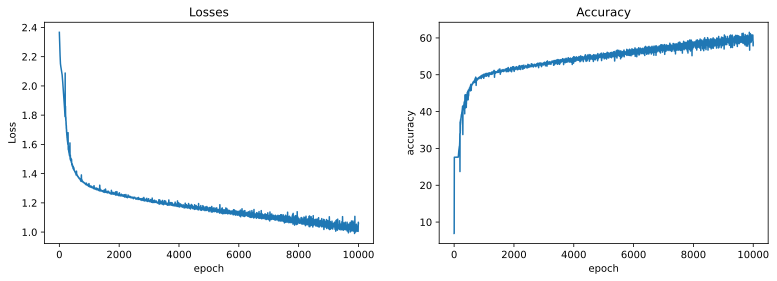

In [160]:
# report accuracy
print('Final accuracy: %g%%' %total_acc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(epoch_accuracy)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()